<a href="https://colab.research.google.com/drive/1Yh-M4nmlcsqjBGTVXxQErR5LF42KzdqH" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Auto-Encoder(CAE)

## 1. Load dataset

In [15]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_3000.zip -d ./data3000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/__main__.py", line 158, in main
    download_folder(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download_folder.py", line 325, in download_folder
    local_path = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 202, in download
    res = sess.get(url, stream=True, verify=verify)
  File "/usr/local/lib/python3.10/dist-packages/requests/sessions.py", line 602, in get
    return self.request("GET", url, **

## 2. Import python libraries and define util functions

In [18]:
!pip install torchsummary

In [19]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

In [20]:
set_seed(0)

## 3. Check dataset

In [21]:
path = './data3000/24.0008.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [22]:
# image size = 56 x 56, 3000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data3000/'

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
    X.append(img_read(src,file)/255.)  # normalize the image
    Y.append(float(file[:-4]))  # extract label from filename

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X.shape:',np.shape(X),'Y.shape:',np.shape(Y))

X.shape: (3000, 56, 56) Y.shape: (3000,)


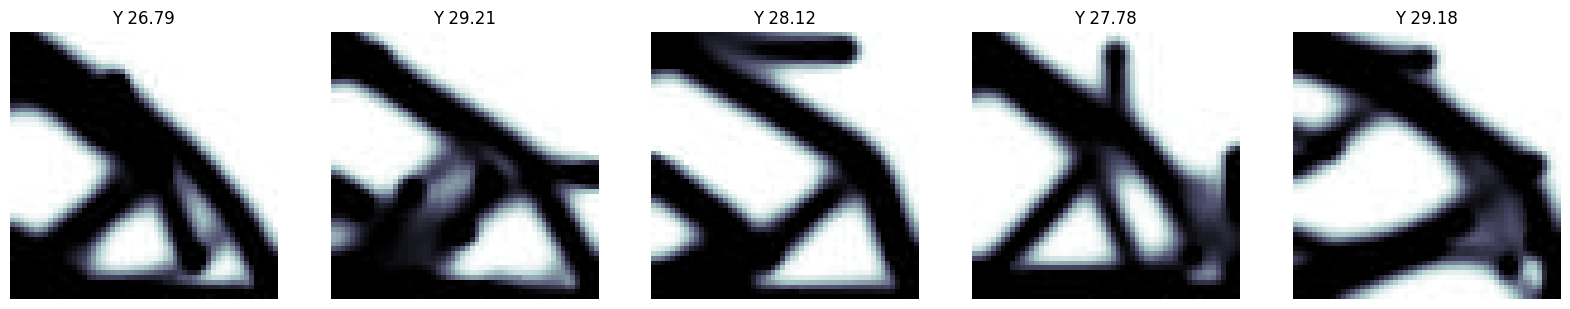

In [23]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X[i, :, :],cmap = plt.cm.bone)
    ax.set_title(f"Y {Y[i]:.2f}")
    ax.axis('off')
plt.show()

In [31]:
# split the data into 80% training set and 20% test set (test set can be considered as validation)
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
train_images  =  2* train_images - 1
test_images  =  2* test_images - 1
# print the shapes and types of the training and test datasets
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

print(np.shape(train_labels),np.shape(test_labels))
print(type(train_labels), type(test_labels))

# reshape the (image,image) images into (image*image,) size vectors
#train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:]))).astype('float32')
#test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:]))).astype('float32')


print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(train_images),np.shape(test_images)))

# convert data to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(test_images, dtype=torch.float32).to(device).unsqueeze(1)
test_labels = torch.tensor(test_labels, dtype=torch.float32)   # don't need to use labels

(2400, 56, 56) (600, 56, 56)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2400,) (600,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Datasets_train_shape:(2400, 56, 56)  Datasets_test_shape:(600, 56, 56)


## 5. Set to model architecture

In [32]:
class ConvAutoencoder(nn.Module):
    def __init__(self, conv_layers_channels=[16, 32, 64], conv_transpose_layers_channels=None):
        super(ConvAutoencoder, self).__init__()
        if conv_transpose_layers_channels is None:
            conv_transpose_layers_channels = conv_layers_channels[::-1]
            conv_transpose_layers_channels[-1] = 1
        num_conv_t_layers = len(conv_transpose_layers_channels)
        # automatically determine the number of convolutional layers
        num_conv_layers = len(conv_layers_channels)

        # define the convolutional layers
        self.encoder = nn.ModuleList()
        in_channels = 1  # input channels (1 for grayscale images)
        for i in range(num_conv_layers-1):
            out_channels = conv_layers_channels[i]
            self.encoder.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1))
            self.encoder.append(nn.ReLU())
#            self.encoder.append(nn.MaxPool2d(kernel_size=2))
            in_channels = out_channels  # set the output channels of this layer as input for the next layer
        out_channels = conv_layers_channels[num_conv_layers-1]
        self.encoder.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1))


        self.decoder = nn.ModuleList()
        in_channels = out_channels  # input channels (1 for grayscale images)
        out_channels = conv_transpose_layers_channels[0]
        for i in range(num_conv_t_layers-1):
            out_channels = conv_transpose_layers_channels[i]
            self.decoder.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))
            self.decoder.append(nn.ReLU())
            in_channels = out_channels  # set the output channels of this layer as input for the next layer
        out_channels = conv_transpose_layers_channels[num_conv_t_layers-1]
        self.decoder.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))

#        self.decoder.append(nn.MaxPool2d(kernel_size=32))
    def forward(self, x):
        # pass the input through the convolutional layers with ReLU and MaxPooling
        for conv in self.encoder:
            x = conv(x)
        for conv in self.decoder:
            x = conv(x)
        return x

## 6. Set model hyperparameters

In [33]:
conv_layers_channels = [32,64,128]
#conv_transpose_layers_channels = [128,64,32]
cae = ConvAutoencoder(conv_layers_channels=conv_layers_channels).to(device)

summary(cae, (1, 56, 56))  # input shape: (channels, height, width)

cae  # print model architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 7, 7]         131,200
   ConvTranspose2d-6          [-1, 128, 14, 14]         147,584
              ReLU-7          [-1, 128, 14, 14]               0
   ConvTranspose2d-8           [-1, 64, 28, 28]          73,792
              ReLU-9           [-1, 64, 28, 28]               0
  ConvTranspose2d-10            [-1, 1, 56, 56]             577
Total params: 371,969
Trainable params: 371,969
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.79
Params size (MB): 1.42
Estimated T

ConvAutoencoder(
  (encoder): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): ModuleList(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [34]:
learning_rate = 0.001;num_epochs=100
batch_size = 32

## 7. Train model

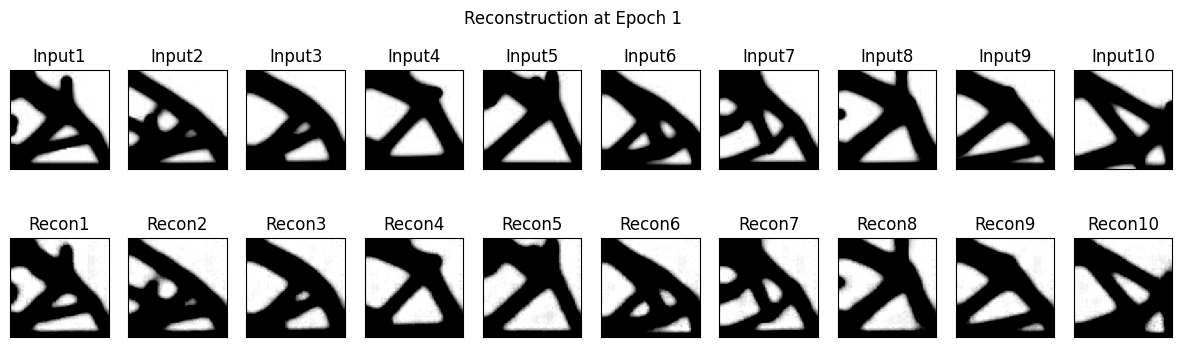

Epoch [1/100], Train_loss: 0.1244
Epoch [2/100], Train_loss: 0.0084
Epoch [3/100], Train_loss: 0.0049
Epoch [4/100], Train_loss: 0.0037
Epoch [5/100], Train_loss: 0.0030
Epoch [6/100], Train_loss: 0.0028
Epoch [7/100], Train_loss: 0.0023
Epoch [8/100], Train_loss: 0.0022
Epoch [9/100], Train_loss: 0.0019
Epoch [10/100], Train_loss: 0.0018
Epoch [11/100], Train_loss: 0.0018
Epoch [12/100], Train_loss: 0.0016
Epoch [13/100], Train_loss: 0.0016
Epoch [14/100], Train_loss: 0.0016
Epoch [15/100], Train_loss: 0.0013
Epoch [16/100], Train_loss: 0.0014
Epoch [17/100], Train_loss: 0.0015
Epoch [18/100], Train_loss: 0.0011
Epoch [19/100], Train_loss: 0.0012
Epoch [20/100], Train_loss: 0.0011
Epoch [21/100], Train_loss: 0.0012
Epoch [22/100], Train_loss: 0.0012
Epoch [23/100], Train_loss: 0.0010
Epoch [24/100], Train_loss: 0.0011
Epoch [25/100], Train_loss: 0.0010
Epoch [26/100], Train_loss: 0.0010
Epoch [27/100], Train_loss: 0.0010
Epoch [28/100], Train_loss: 0.0010
Epoch [29/100], Train_loss: 0

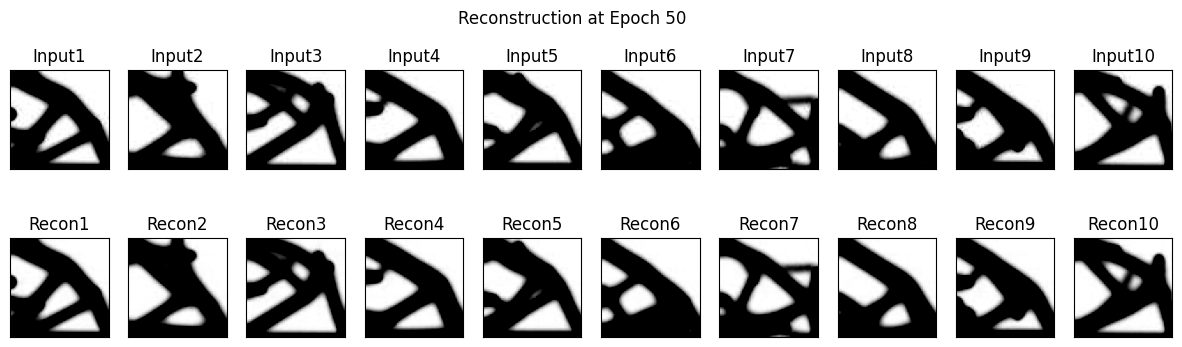

Epoch [50/100], Train_loss: 0.0009
Epoch [51/100], Train_loss: 0.0006
Epoch [52/100], Train_loss: 0.0006
Epoch [53/100], Train_loss: 0.0006
Epoch [54/100], Train_loss: 0.0006
Epoch [55/100], Train_loss: 0.0007
Epoch [56/100], Train_loss: 0.0006
Epoch [57/100], Train_loss: 0.0008
Epoch [58/100], Train_loss: 0.0005
Epoch [59/100], Train_loss: 0.0006
Epoch [60/100], Train_loss: 0.0007
Epoch [61/100], Train_loss: 0.0005
Epoch [62/100], Train_loss: 0.0006
Epoch [63/100], Train_loss: 0.0005
Epoch [64/100], Train_loss: 0.0006
Epoch [65/100], Train_loss: 0.0006
Epoch [66/100], Train_loss: 0.0005
Epoch [67/100], Train_loss: 0.0006
Epoch [68/100], Train_loss: 0.0006
Epoch [69/100], Train_loss: 0.0005
Epoch [70/100], Train_loss: 0.0006
Epoch [71/100], Train_loss: 0.0005
Epoch [72/100], Train_loss: 0.0006
Epoch [73/100], Train_loss: 0.0005
Epoch [74/100], Train_loss: 0.0005
Epoch [75/100], Train_loss: 0.0005
Epoch [76/100], Train_loss: 0.0007
Epoch [77/100], Train_loss: 0.0004
Epoch [78/100], Trai

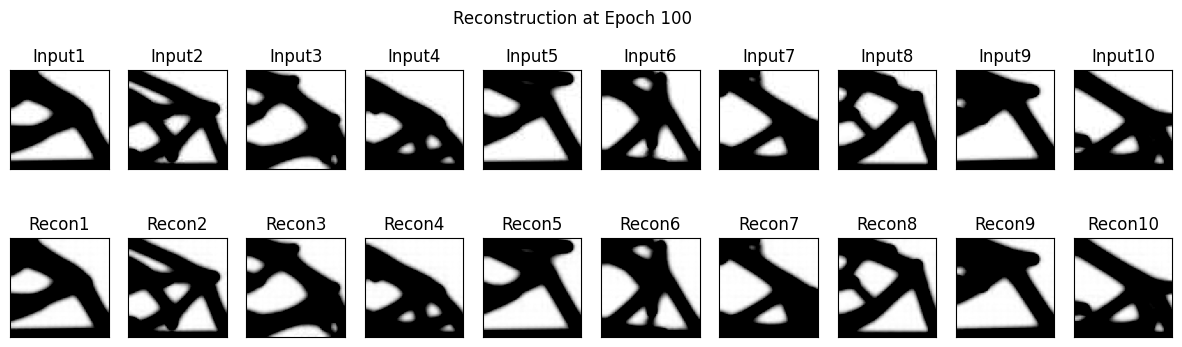

Epoch [100/100], Train_loss: 0.0004


In [35]:
# create a DataLoader for the training data
train_dataset = TensorDataset(train_images, train_images)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
n = 10
# set to loss function & optimizer

# define optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(cae.parameters(), lr=learning_rate)
average_loss_trains = []
# train the VAE model
for epoch in range(num_epochs):
    total_loss = 0.0
    cae.train()
    for x, _ in train_loader:
        x = x.unsqueeze(1)
        optimizer.zero_grad()
        output = cae(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if (epoch + 1) % 50 == 0 or epoch == 0:
        n = 10  # how many images to display
        plt.figure(figsize=(15, 4)) # figure size
        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(x.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Input{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(output.detach().cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Recon{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
        plt.show()

    average_loss_train = total_loss / len(train_loader)
    average_loss_trains.append(average_loss_train)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train:.4f}")

# save the trained model
torch.save(cae.state_dict(), 'CAE_model.pth')

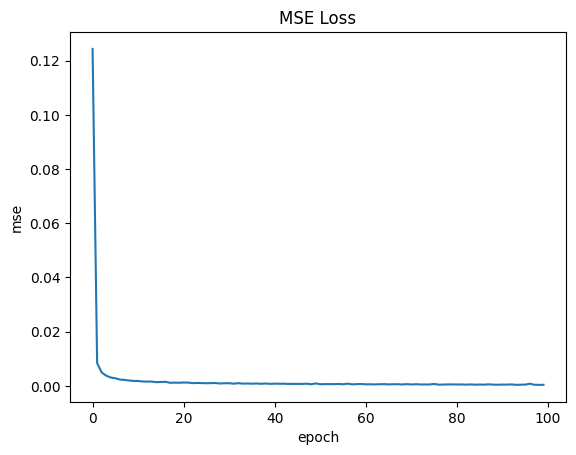

In [36]:
plt.plot(average_loss_trains)
plt.title("MSE Loss")
plt.xlabel("epoch")
plt.ylabel("mse");

## 8. Load & Evaluate model

- Compare the orginial image and the reconstructed image

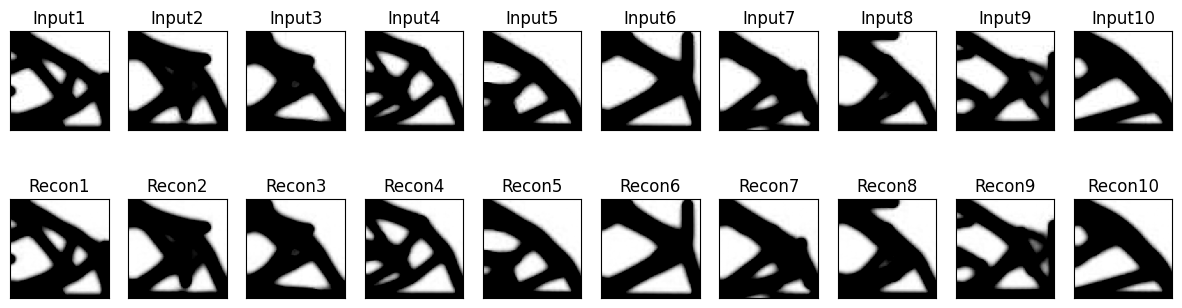

In [ ]:
cae.eval().to(device)

# proceed reconstruction of the bracket images through the trained autoencoder model
test_images = test_images#.unsqueeze(1)
recon_x_test = cae(test_images)
n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.squeeze().cpu()[i], vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Input"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.squeeze().detach().cpu()[i],vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Recon"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()